In [1]:
from PIL import Image
import json
import os
import random
import pandas as pd
import re

In [2]:
image_folder='/rcfs/projects/steel_thread/hora620/hf/hub/vistext/data/images'

In [23]:
split="validation"#train,test,validation
data_path=f'/rcfs/projects/steel_thread/hora620/hf/hub/vistext/data/data_{split}.json'
scicap_val = json.load(open(data_path, "r"))
# scicap_val_images=pd.DataFrame(scicap_val)

scicap_val_annotations=pd.DataFrame(scicap_val)


# data_path='/qfs/projects/steel_thread/hora620/DevHub/scientific-instruction-tuning/Grounded-Segment-Anything/results/scicap_val/type_clf.json'
# scipcap_preds = json.load(open(data_path, "r"))

In [4]:

data_path="/rcfs/projects/steel_thread/models/LLAVA-7b-pretrain-scitune-333472-v2-13B/vistext/llava_val_vistext_prediction_caption_L1_1202.jsonl"
scitune_preds=pd.read_json(data_path,lines=True)
# scitune_preds_with_gt=pd.merge(scitune_preds,scicap_val,left_on='question_id',right_on='id',how='inner')
# print(scitune_preds_with_gt.shape[0])

# figure_types=['Graph Plot','Scatterplot','Node Diagram','Equation','Bar Chart']
# def get_scitune_figure_tye_pred(text):
#     for k in figure_types:
#         if k in text:
#             return k

# scitune_preds['scitune_figure_type']=scitune_preds['text'].apply(get_scitune_figure_tye_pred)

## Figure Type Generation Performance

In [ ]:
clip_preds=[]
for pred in scipcap_preds:
    cip_pred={}
    cip_pred['id']=pred['id']
    type_clf_df=pd.DataFrame(pred['type_clf'])
    #print(type_clf_df.iloc[type_clf_df['score'].idxmax()])
    cip_pred['clip_figure_type']=type_clf_df.iloc[type_clf_df['score'].idxmax()]['label']
    clip_preds.append(cip_pred)
clip_preds=pd.DataFrame(clip_preds)
print(clip_preds.shape[0])

In [ ]:
scicap_val_with_preds=pd.merge(scicap_val_images,clip_preds,on='id',how='inner')
scicap_val_with_preds=pd.merge(scicap_val_with_preds,scitune_preds,left_on='id',right_on='question_id',how='inner')

In [ ]:
scicap_val_with_preds.head()

In [ ]:
scicap_val_with_preds['clip_accuracy']=(scicap_val_with_preds['figure_type']==scicap_val_with_preds['clip_figure_type']).astype(int)
scicap_val_with_preds['scitune_accuracy']=(scicap_val_with_preds['figure_type']==scicap_val_with_preds['scitune_figure_type']).astype(int)

In [ ]:
scicap_val_with_preds['clip_accuracy'].mean(),scicap_val_with_preds['scitune_accuracy'].mean()

In [ ]:
scicap_val_with_preds.groupby('figure_type')['clip_accuracy'].mean(),scicap_val_with_preds.groupby('figure_type')['scitune_accuracy'].mean()

## Figure Captioning

In [6]:
import evaluate
from tqdm import tqdm
tqdm.pandas()
bleu_metric = evaluate.load('google_bleu')
rouge_metric = evaluate.load('rouge')


/people/hora620/.conda/envs/llava/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
data_path='/qfs/projects/steel_thread/hora620/DevHub/scientific-instruction-tuning/Grounded-Segment-Anything/results/vistext_val/captions.json'
blip_preds = pd.DataFrame(json.load(open(data_path, "r")))

In [26]:
blip_preds['question_id']=blip_preds['id'].apply(lambda x:int(x.replace('_','')))

In [48]:
scicap_val_annotations.head()

,caption_id,img_id,split,scenegraph,datatable,caption_L1,caption_L2L3,L1_properties
0,3_01,3,validation,title Worldwide number of Michelin 's full-tim...,Worldwide number of Michelin 's full-time empl...,This is a area plot labeled Worldwide number o...,employees have remained pretty stable througho...,"[area, Worldwide number of Michelin 's full-ti..."
1,3_02,3,validation,title Worldwide number of Michelin 's full-tim...,Worldwide number of Michelin 's full-time empl...,This is a area plot labeled Worldwide number o...,The worldwide number of full time employees is...,"[area, Worldwide number of Michelin 's full-ti..."
2,18_01,18,validation,title Top 10 U.S. metro areas by plastic surge...,Top 10 U.S. metro areas by plastic surgeon den...,This bar chart is titled Top 10 U.S. metro are...,The highest density of plastic surgeons is in ...,"[bar, Top 10 U.S. metro areas by plastic surge..."
3,18_02,18,validation,title Top 10 U.S. metro areas by plastic surge...,Top 10 U.S. metro areas by plastic surgeon den...,This bar chart is titled Top 10 U.S. metro are...,Every city included had at least 2 plastic sur...,"[bar, Top 10 U.S. metro areas by plastic surge..."
4,23_01,23,validation,title Number of passengers traveling with TAP ...,Number of passengers traveling with TAP Portug...,This area diagram is titled Number of passenge...,the number of passengers travelling each year ...,"[area, Number of passengers traveling with TAP..."


In [77]:
scitune_preds_with_caption=pd.merge(scitune_preds,blip_preds,on='question_id')
scitune_preds_with_caption=pd.merge(scitune_preds_with_caption,scicap_val_annotations[['caption_id','caption_L1']],left_on='id',right_on='caption_id')

In [80]:
scitune_preds_with_caption.head()

,question_id,prompt,text,answer_id,model_id,metadata,id,image,caption,caption_id,caption_L1,scitune_text
0,301,Give an elaborate explanation of the image you...,Assistant: Bar Chart Cumulative number of empl...,bkDjUeb387Ss3VFXRyf3fQ,/rcfs/projects/steel_thread/models/LLAVA/13B,{},3_01,3.png,a graph showing the number of employees in the...,3_01,This is a area plot labeled Worldwide number o...,Cumulative number of employees who have work...
1,302,Explain the various aspects of the image befor...,Assistant: Graph Plot The number of MICHELIN e...,5BsZz9AUiLoMpJN82MzGuT,/rcfs/projects/steel_thread/models/LLAVA/13B,{},3_02,3.png,a graph showing the number of employees in the...,3_02,This is a area plot labeled Worldwide number o...,The number of MICHELIN employees (from 2005 ...
2,1801,Provide a detailed description of the given im...,Assistant:\n The answer is The map on the left...,TevmmtFCmRjpfr7HcbJQ5i,/rcfs/projects/steel_thread/models/LLAVA/13B,{},18_01,18.png,arafed bar graph of the number of surgeons per...,18_01,This bar chart is titled Top 10 U.S. metro are...,The answer is The map on the left depicts the...
3,1802,Explain the various aspects of the image befor...,Assistant:\n The answer is The number of surge...,bofvY4zbsW3Yd7C8Sc8DyS,/rcfs/projects/steel_thread/models/LLAVA/13B,{},18_02,18.png,arafed bar graph of the number of surgeons per...,18_02,This bar chart is titled Top 10 U.S. metro are...,The answer is The number of surgeries per 100...
4,2301,Provide a detailed description of the given im...,Assistant: Graph Plot Number of passengers tra...,2fYFW2uH3b69qRndQqQBRk,/rcfs/projects/steel_thread/models/LLAVA/13B,{},23_01,23.png,arafed graph of passenger travelling with ta i...,23_01,This area diagram is titled Number of passenge...,Number of passengers traveling with TAP from...


In [79]:

scitune_preds_with_caption['text']=scitune_preds_with_caption['text'].apply(lambda x:x.replace('ASSIST:','Assistant:'))
scitune_preds_with_caption['scitune_text']=scitune_preds_with_caption['text'].apply(lambda x:x.split('Assistant:')[1].lstrip('\n').split('\n')[0])
scitune_preds_with_caption['scitune_text']=scitune_preds_with_caption['scitune_text'].apply(lambda x:x.replace('Assistant:',''))
for _ in ['Graph Plot','Scatterplot','Node Diagram','Equation','Bar Chart']:
    scitune_preds_with_caption['scitune_text']=scitune_preds_with_caption['scitune_text'].apply(lambda x:x.replace(_,''))

In [81]:

## only BLEU + ROUGE for time
metric_types = ['bleu', 'rouge']
metrics = [bleu_metric, rouge_metric]
metric_kwargs = [{}, {}]
metric_keys = ['google_bleu', 'rougeL']

pred_output_types = ['scitune_text', 'caption']
for pred_output_type in pred_output_types:
    for metric_type, metric_kwarg, metric, metric_key in zip(metric_types, metric_kwargs, metrics, metric_keys):
        metric_col = f'{pred_output_type}_{metric_type}'
#         if(metric_col not in results_outputs_with_metadata.columns):
        scitune_preds_with_caption = scitune_preds_with_caption.assign(**{
            metric_col : scitune_preds_with_caption.progress_apply(
                lambda x: metric.compute(
                    predictions=[x.loc[pred_output_type]], 
                    references=[[x.loc['caption_L1']]],
                    **metric_kwarg
                )[metric_key], axis=1
            )
        })


100%|██████████| 1202/1202 [02:54<00:00,  6.90it/s]


In [82]:

## just the caption
print("SciTune BLUE",scitune_preds_with_caption['scitune_text_bleu'].mean(),scitune_preds_with_caption['scitune_text_bleu'].std())
print("SciTune ROUGE",scitune_preds_with_caption['scitune_text_rouge'].mean(),scitune_preds_with_caption['scitune_text_rouge'].std())

print("BLIP BLUE",scitune_preds_with_caption['caption_bleu'].mean(),scitune_preds_with_caption['caption_bleu'].std())
print("BLIP ROUGE",scitune_preds_with_caption['caption_rouge'].mean(),scitune_preds_with_caption['caption_rouge'].std())

SciTune BLUE 0.09598398993689515 0.0738241444776161
SciTune ROUGE 0.23145864868248303 0.12141017972331786
BLIP BLUE 0.06282723915092647 0.04867878917368778
BLIP ROUGE 0.2309265532343711 0.1149759887479741


In [ ]:
# ## caption + OCR + mentions
# print("SciTune BLUE",scitune_preds_with_caption['text_bleu'].mean())
# print("SciTune ROUGE",scitune_preds_with_caption['text_rouge'].mean())

# print("BLIP BLUE",scitune_preds_with_caption['caption_bleu'].mean())
# print("BLIP ROUGE",scitune_preds_with_caption['caption_rouge'].mean())

In [83]:
X=scitune_preds_with_caption[scitune_preds_with_caption['scitune_text_rouge']>0.25].sort_values(by='scitune_text_rouge',ascending=False)

Image ID:  7570_02
GT:  Here a bar plot is titled Average retail price for chicken in Canada from January 2015 to June 2020 (in Canadian dollars per kilogram). The y-axis plots 2020 while the x-axis shows Month.
BLIP:  a graph showing average price for chicken in canada from january to june 2020
SciTune:    Average retail price for chicken in Canada from January 2015 to June 2020 in Canadian currency.


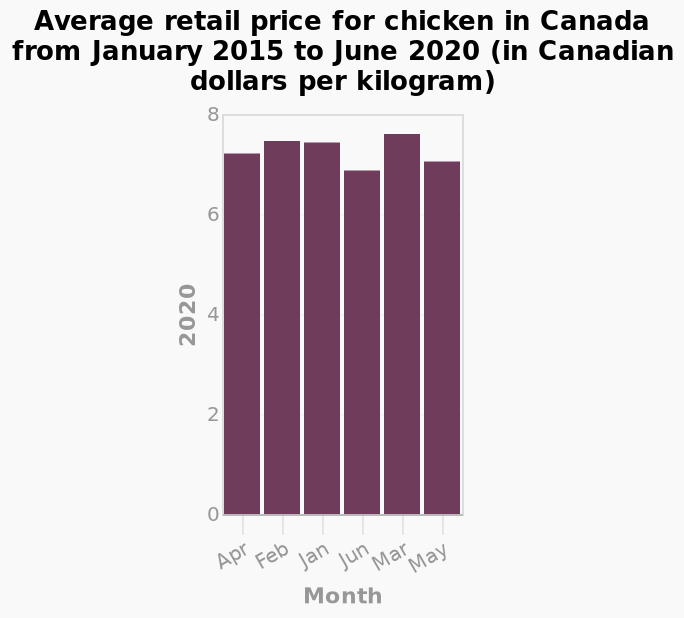

In [85]:
index=1
print("Image ID: ",X.iloc[index]['id'])
print("GT: ",X.iloc[index]['caption_L1'])
print("BLIP: ",X.iloc[index]['caption'])
print("SciTune: ",X.iloc[index]['scitune_text'])
image_file=X.iloc[index]['image']
image = Image.open(os.path.join(image_folder, image_file)).convert('RGB')
image